In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

## **The dataset is shown below:**

In [102]:
data_df = pd.read_csv('../data/CreditPrediction.csv')
# removing duplicated datas
data_no_dup = data_df.drop_duplicates() 
# data_no_dup = data_no_dup.fillna(0)
# data_no_dup = pd.get_dummies(data_no_dup, columns=['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'], drop_first=True, )

data_no_dup

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 19
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,NaN
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,NaN
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,NaN
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,NaN
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,712110333,37.0,F,3,High School,NaN,Unknown,NaN,18.0,4.0,1,3,2179.0,0,0.725,2568,48,0.297,0.000,NaN
10134,712674183,53.0,M,2,College,NaN,$40K - $60K,Blue,33.0,3.0,3,1,4065.0,2180,0.321,1271,36,0.200,0.536,NaN
10135,718421808,56.0,F,2,Uneducated,Married,Unknown,Blue,43.0,6.0,3,2,3068.0,1765,0.853,4611,73,0.698,0.575,NaN
10136,809452383,37.0,F,2,Graduate,Married,Less than $40K,NaN,32.0,6.0,1,3,1438.3,0,0.707,4733,89,0.816,0.000,NaN


In [103]:
def fix_missing_values(df):
    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(exclude='object').columns
    cat_cols = df.select_dtypes(include='object').columns

    # Create transformers for numerical and categorical data
    num_transformer = IterativeImputer()
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

    # Apply the transformations
    preprocessed_data = preprocessor.fit_transform(data_no_dup)

    # Convert the result back to a DataFrame (optional)
    preprocessed_df = pd.DataFrame(preprocessed_data)

    # Display the preprocessed DataFrame
    return preprocessed_df

In [104]:
X = data_no_dup.drop('Credit_Limit', axis=1)
y = data_no_dup['Credit_Limit']

X = fix_missing_values(X)


c:\Users\Kianoosh\anaconda3\envs\pytorch\Lib\site-packages\sklearn\impute\_base.py:597: UserWarning: Skipping features without any observed values: [13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [140]:
 
# feature selection
def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=mutual_info_regression, k=26)
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


In [141]:
# load the dataset
# split into train and test sets
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

c:\Users\Kianoosh\anaconda3\envs\pytorch\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Feature 0: 0.003698
Feature 1: 0.025399
Feature 2: 0.050603
Feature 3: 0.031632
Feature 4: 0.057239
Feature 5: 0.073621
Feature 6: 0.058978
Feature 7: 0.156111
Feature 8: 0.021971
Feature 9: 0.124276
Feature 10: 0.073115
Feature 11: 0.014763
Feature 12: 0.803262
Feature 13: 0.228071
Feature 14: 0.228529
Feature 15: 0.140301
Feature 16: 0.145474
Feature 17: 0.098656
Feature 18: 0.121454
Feature 19: 0.139515
Feature 20: 0.132446
Feature 21: 0.121434
Feature 22: 0.142566
Feature 23: 0.105316
Feature 24: 0.118416
Feature 25: 0.148179
Feature 26: 0.196802
Feature 27: 0.156184
Feature 28: 0.144025
Feature 29: 0.183886
Feature 30: 0.258041
Feature 31: 0.150099
Feature 32: 0.240529
Feature 33: 0.176022
Feature 34: 0.146098
Feature 35: 0.218604
0


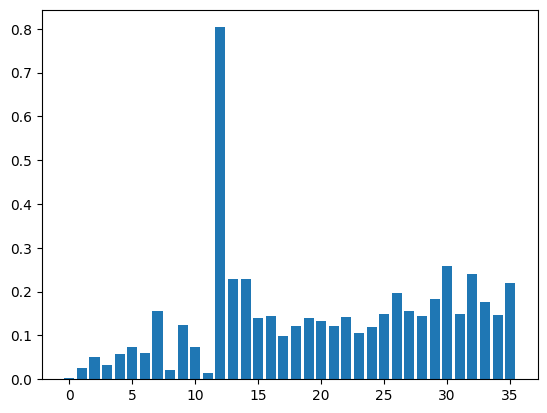

In [142]:
# what are scores for the features
ignr_cnt = 0
for i in range(len(fs.scores_)):
 if (fs.scores_[i] < 0.0015):
  ignr_cnt +=1
 print('Feature %d: %f' % (i, fs.scores_[i]))
print(ignr_cnt)
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [143]:
X_train_fs = np.array(X_train_fs) 
X_test_fs = np.array(X_test_fs) 

y_train = np.array(y_train) 
y_test = np.array(y_test) 

In [144]:
X_train_fs = torch.from_numpy(X_train_fs.astype(np.float32))
X_test_fs = torch.from_numpy(X_test_fs.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))


y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

_, n_features = X_train_fs.shape



In [155]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        # out = self.sigmoid(out)
        return out

In [156]:
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.linear3 = nn.Linear(int(hidden_size/2), int(hidden_size/4))
        self.linear4 = nn.Linear(int(hidden_size/4), 1)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        out = self.relu(out)
        out = self.linear4(out)
        # out = self.sigmoid(out)
        return out

In [159]:
model = Model(n_features , 50)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [160]:
num_epochs = 1000000
learning_rate = 0.001
criterion = nn.MSELoss()  ####################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lambda_reg = 0.01

for epoch in range(num_epochs):
    # Forward pass and loss
    y_pred = model(X_train_fs)
    loss = criterion(y_pred, y_train)

    # # Compute L2 regularization term
    l2_reg = torch.tensor(0.)
    for param in model.parameters():
        l2_reg += torch.norm(param)
    
    # Add regularization term to loss
    loss += lambda_reg * l2_reg

    # Backward pass and update

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # zero grad before new step

    if (epoch+1) % 1000 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


epoch: 1000, loss = 32840698.0000
epoch: 2000, loss = 29954936.0000
epoch: 3000, loss = 28071990.0000
epoch: 4000, loss = 26444748.0000
epoch: 5000, loss = 24917020.0000
epoch: 6000, loss = 23516480.0000
epoch: 7000, loss = 22342314.0000
epoch: 8000, loss = 21393666.0000


KeyboardInterrupt: 

In [114]:
from sklearn.metrics import mean_squared_error
with torch.no_grad():
    y_predicted = model(X_test_fs)
    # y_predicted = np.array(y_predicted)
     
    MSE = mean_squared_error(y_predicted, y_test)
MSE

42627244.0